# An Application to Mango Patchiness Analysis

Recently, a statistical methodology has been proposed to characterize plant patchiness at the plant scale [[FDDPLNG16](http://ieeexplore.ieee.org/abstract/document/7818290)].
However, little is known about patchiness at the whole population scale.
To characterize patchiness at the plant scale, a segmentation/clustering of tree-indexed data method has been proposed in order to split an heterogeneous tree into multiple homogeneous subtrees.
After the clustering, the tree can be summarized into a multivariate count denoting the number of subtrees in each cluster (i.e., patch type).
Mixture of multinomial splitting distributions can therefore be considered to recover the different types of tree patchiness that can be found in the plant population.
Such a mixture model is of high interest since it enables to discriminate the types of tree patchiness according to the :

* number of patches present on trees, by fitting different sum distributions within components of the mixture model,
* distribution of these patches among types, by fitting different singular distributions within components of the mixture model.

We here consider results presented by [[FDDPLNG16](http://ieeexplore.ieee.org/abstract/document/7818290)] to conduct our *post-hoc* analysis.
Three different types of patches have been identified for mango trees: vegetative patches which contain almost only vegetative growth units (GU, plant elementary component), reproductive patches which contain almost only GUs that flowered or fructified and quiescent patches which contain GUs that did not burst, flowered nor fructified.

First, we need:
    
* to import `matplotlib` package.

In [1]:
import matplotlib
%matplotlib nbagg
from matplotlib import pyplot

* to import `linalg` and `core` modules of the `statiskit` package.

In [2]:
from statiskit import (linalg,
                       core)

* to load the dataset.

In [3]:
from statiskit.data import core as data
data = data.load('FPD18')

Multinomial splitting distributions of mixture components were of dimension $3$, where $N_0$ (resp. $N_1$ and $N_2$) denotes the number of vegetative (resp. reproductive and quiescent) patches observed within a tree.
Only the multinomial and the Dirichlet multinomial  were considered for the singular distribution.
Within each component the parametric form of the singuar distribution was selected using the BIC.

In [4]:
singular_estimator = core.singular_selection('MN', 'DM')

Since there is at least one patch in a mango tree (i.e., the tree itself), shifted singular multinomial splitting distributions were considered with a shift equal to $1$ for binomial, negative binomial and Poisson sum distributions but without shift for geometric and logarithmic distributions.
Within each component the parametric form of the sum distribution was selected using the BIC.

In [5]:
sum_estimator = core.shifted_estimation(core.outcome_type.DISCRETE,
                                        shift = 1,
                                        estimator = core.selection(core.outcome_type.DISCRETE,
                                                                   estimators = [core.poisson_estimation('ml'),
                                                                                 core.binomial_estimation('ml'),
                                                                                 core.negative_binomial_estimation('ml')]))
sum_estimator = core.selection(core.outcome_type.DISCRETE,
                               estimators = [sum_estimator,
                                             core.geometric_estimation('ml'),
                                             core.logarithmic_estimation('ml')])

With `singular_estimator` and `sum_estimator` we are now able to construct an estimator for a splitting distribution.

In [6]:
estimator = core.splitting_estimation(sum = sum_estimator,
                                      singular = singular_estimator)

The initilization of the EM alogrithm is made with a mixture of $27$ components with slight differences concerning multinomial singular distribution probabilities.

In [7]:
import itertools
pi = [1.] * len(data.components)
components = []
# product set {1., 2., 3.}^3
# alpha is the parameter of a singular multinomial distribution and is normalized
# in the constructor
# The weights of the components are 1. (unnormalized) -> 1/27
# The components can be seen with "print(components)"
for alpha in itertools.product(*([(1.,2.,3.)] * 3)):
    components.append(core.SplittingDistribution(core.PoissonDistribution(1.),
                                                 core.MultinomialSingularDistribution(linalg.Vector(alpha))))
initializator = core.MixtureDistribution(*components,
                                         pi = linalg.Vector([1.] * len(components)))
mixest = [core.mixture_estimation(data, 'em',
                                  initializator = initializator,
                                  default_estimator = estimator)]

We then estimate the mixture models with an initialization were components less observed *a posteriori* are successively removed.

In [8]:
while len(components) > 2:
    assignment = list(mixest[-1].estimated.assignment(data))
    components.pop(min(set(assignment), key=assignment.count))
    initializator = core.MixtureDistribution(*components,
                                             pi = linalg.Vector([1.] * len(components)))
    mixest.append(core.mixture_estimation(data, 'em',
                                           initializator = initializator,
                                           default_estimator = estimator, maxits=100))

We also considered the case where there is only one component.

In [9]:
mixest.append(estimator(data, False))
mixest = list(reversed(mixest))

To select the best number of components, we used the BIC.

<IPython.core.display.Javascript object>


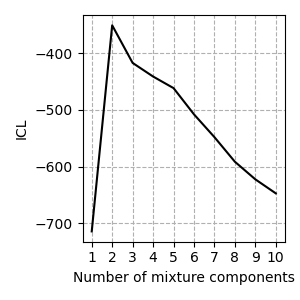

In [10]:
import math
Sm = [result.estimated.loglikelihood(data) for result in mixest]
Dm = [mixest[0].estimated.nb_parameters] + [result.estimated.nb_parameters for result in mixest[1:]]
BICm = [s - d * math.log(data.total) / 2 for s, d in zip(Sm, Dm)]
Cm = [1] + [result.estimated.nb_states for result in mixest[1:]]
Um = [0] + [result.estimated.uncertainty(data) for result in mixest[1:]]
ICLm = [bic - u for (bic, u) in zip(BICm, Um)]
limit = 10
fig = pyplot.figure(figsize=(3,3))
axes = fig.add_subplot(111)
axes.plot(Cm[:limit], ICLm[:limit], color='k')
axes.set_xticks(range(1, limit + 1))
axes.set_xlabel('Number of mixture components')
axes.set_ylabel('ICL')
axes.grid(linestyle='--')
pyplot.tight_layout()
try:
    fig.savefig('selection.pgf')
except:
    pass
fig.savefig('selection.svg')

The best number of components is $2$ with relatively similar representation

In [11]:
mixest[1].estimated.pi

[0.43913037117206394]
[  0.560869628827936]

In component $1$, the best observation distribution is a multinomial splitting shifted negative binomiale .

In [12]:
mixest[1].estimated.observations[0]

M(S, [   0.2099871562583681]
[4.501139694135519e-05]
[   0.7899678323446905]) /\ NB(0.1631655417482264, 0.7624334099963209, 1)

This is also true in component $2$

In [13]:
mixest[1].estimated.observations[1]

M(S, [0.5437471507484111]
[0.1749488303738908]
[0.2813040188776981]) /\ NB(3.96359565455258, 0.40071571638942627, 1)

To appreciate the fit of this model, on can look at the fit of the sum distributions for example.

<IPython.core.display.Javascript object>


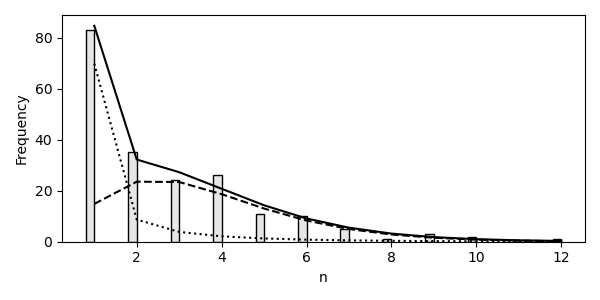

In [14]:
sum_data = core.from_list([sum([event.value for event in events]) for events in data.events])
dist = mixest[1].estimated
fig = pyplot.figure(figsize=(6,3))
sum_dist = core.MixtureDistribution(dist.observations[0].sum,
                                    dist.observations[1].sum,
                                    pi = dist.pi)
axes = sum_dist.pdf_plot(axes = fig.add_subplot(111),
                         color = 'k',
                         fmt = '-',
                         norm = sum_data.total,
                         qmin = sum_data.min.value,
                         qmax = sum_data.max.value,
                         states = [dict(fmt = ':'),
                                   dict(fmt = '--')])
axes = sum_data.pdf_plot(axes = axes, color='#e6e6e6',
                                      edgecolor='k')
axes.set_xlabel('n')
axes.set_ylabel('Frequency')
pyplot.tight_layout()
try:
    fig.savefig('sum.pgf')
except:
    pass
fig.savefig('sum.svg')

Note that if we consider only $1$ component, the best model is a Dirichlet multinomial splitting geometric distribution.

In [15]:
mixest[0].estimated

DM(S, [ 3.067705285098288]
[0.8679624628318171]
[  2.98830062597658]) /\ G(0.6318681318681323)

Means for sum distributions in both components

In [16]:
dist.observations[0].sum.mean

1.5236546956668895

In [17]:
dist.observations[1].sum.mean

3.650286542845741

Numpy conversion of mixture proportions

In [18]:
import numpy as np

In [19]:
np_rho = np.array([dist.pi[i] for i in range(dist.pi.nb_rows)])

Get model parameters and probabilities

In [20]:
def get_nb_parameters(nb):
    """
    get parameters of a negative binomial distribution    
    """
    s = str(nb.probability)
    i1 = s.find('NB')
    i2 = s.find(',', i1)
    r = float(s[i1+3:i2])
    i3 = s.find(',', i2+1)
    p = float(s[i2+1:i3])
    i4 = s.find(')', i3+1)
    d = int(s[i3+1:i4])
    return (r, p, d)

def probability(y, pi, r, p, delta):
    """
    probability computation for a splitting multinomial - negative binomial 
    distribution 
    """
    from scipy.stats import multinomial, nbinom
    s = y.sum() - delta
    if s >=0:
        m = multinomial(y.sum(), pi) 
        b = nbinom(r, p, delta) 
        pr = m.pmf(y) * b.pmf(y.sum())
        pr = pr[0]
    else:
        pr = 0.0
    return(pr)

pi = np.zeros((len(np_rho), 3))

for i in range(pi.shape[0]):
    for j in range(pi.shape[1]):
        pi[i,j] = dist.observations[i].singular.pi[j]

r = np.zeros((len(np_rho), 1))
pb = np.zeros((len(np_rho), 1))
d = np.zeros((len(np_rho), 1), dtype=np.int64)

for i in range(pi.shape[0]):
    r[i], pb[i], d[i] = get_nb_parameters(dist.observations[i].sum)


Mean counts in each component

In [21]:
dist.observations[0].sum.mean * pi[0,:]

array([3.19947917e-01, 6.85818263e-05, 1.20363820e+00])

In [22]:
dist.observations[1].sum.mean * pi[1,:]

array([1.98483291, 0.63861336, 1.02684027])

Chi-square test for goodness of fit

In [23]:
e = data.events

# count occurrences of each 'event' (vector)
e_counts = {} 
e_counts_keys = []
for i in range(len(e)):
    k = repr(e[i])
    if k in e_counts_keys:
        e_counts[k] += 1
    else:
        e_counts_keys += [k]
        e_counts[k] = 1

Compute probabilities for components and their mixtures

In [24]:
def get_nb_parameters(nb):
    """
    get parameters of a negative binomial distribution    
    """
    s = str(nb.probability)
    i1 = s.find('NB')
    i2 = s.find(',', i1)
    r = float(s[i1+3:i2])
    i3 = s.find(',', i2+1)
    p = float(s[i2+1:i3])
    i4 = s.find(')', i3+1)
    d = int(s[i3+1:i4])
    return (r, p, d)

def probability(y, pi, r, p, delta):
    """
    probability computation for a splitting multinomial - negative binomial 
    distribution 
    """
    from scipy.stats import multinomial, nbinom
    s = y.sum() - delta
    if s >=0:
        m = multinomial(y.sum(), pi) 
        b = nbinom(r, p, delta) 
        pr = m.pmf(y) * b.pmf(y.sum())
        pr = pr[0]
    else:
        pr = 0.0
    return(pr)

def event_to_array(e):
    """
    Conversion from event to numpy.array
    """
    return (np.array(eval(repr(e))))

def mixture_probability(y, rho, pi, r, p, delta):
    """
    probability computation for a mixture of splitting multinomial 
    - negative binomial distributions
    """
    k = len(rho) # number of mixture components
    p = [probability(y, pi[i], r[i], p[i], delta[i]) for i in range(k)]
    p = np.array(p)
    w = np.array(rho)
    return (np.dot(p, w))

probs = {}

for k in e_counts.keys():
    probs[eval(k)] = mixture_probability(np.array(eval(k)), np_rho, pi, r, pb, d)


Sum of probabilities covering observed events (vectors in the sample)

In [25]:
cov_prob = np.array(list(probs.values())).sum()
cov_prob

0.6724851795904897

Extending computed probabilities to $\{0, \ldots, 11\}^3$

In [26]:
full_mixture_probs = {}
for v in itertools.product(*([range(12)] * 3)):
    if np.sum(v) > 0:
        full_mixture_probs[v] = mixture_probability(np.array(v), np_rho, pi, r, pb, d)



Coverage for these probabilities

In [27]:
np.array(list(full_mixture_probs.values())).sum()    

0.9951682494200876

In [28]:
# Complement to 1:
comp = 1 - np.array(list(full_mixture_probs.values())).sum()

Aggregate keys / cells to have more than 5 counts and expected counts per cell


In [29]:
m_keys = list(full_mixture_probs.keys())
nb_m_keys = len(m_keys)
# Mark a key when used in aggregation
mark_m_keys = dict(zip(m_keys, [False]*nb_m_keys))
current_m_k = 0
e_counts_cp = dict([(eval(k), v) for k, v in e_counts.items()])
total_counts = np.array(list(e_counts.values())).sum()
e_counts_n = {}
e_probs_n = {}
for k in e_counts_cp.keys():
    if not(mark_m_keys[k]) and ((e_counts_cp[k] < 6) or \
        (total_counts * full_mixture_probs[k] < 5)):
        current_count = e_counts_cp[k]
        current_e_freq = total_counts * full_mixture_probs[k]
        current_key = [k]
        # enlarge cell
        assert(not(mark_m_keys[k]))
        mark_m_keys[k] = True
        while current_m_k < nb_m_keys and (current_count < 6 or \
            current_e_freq < 5):
            # append free cells in m_keys            
            mk = m_keys[current_m_k] # candidate
            if not(mark_m_keys[mk]):
                if mk in e_counts_cp:
                    current_count += e_counts_cp[mk]
                    current_e_freq += total_counts * full_mixture_probs[mk]
                mark_m_keys[mk] = True
                # Append new key
                current_key += [mk]
            current_m_k += 1            
        if current_m_k < nb_m_keys:
            e_counts_n[str(current_key)] = current_count
            e_probs_n[str(current_key)] = current_e_freq
        else:
            # unmark all event components
            for v in current_key:
                mark_m_keys[v] = False
                e_counts_n.pop(v, None)
                e_probs_n.pop(v, None)
    elif not(mark_m_keys[k]):
        # Mark key
        mark_m_keys[k] = True
        e_counts_n[str([k])] = e_counts_cp[k]
        e_probs_n[str([k])] = total_counts * full_mixture_probs[k]

# group remaining cells

current_key = []
current_count = 0
current_e_freq = 0.
for k in e_counts_cp.keys():
    if not(mark_m_keys[k]):
        current_key += [k]
        current_e_freq += total_counts * full_mixture_probs[k]
        current_count += e_counts_cp[k]
        mark_m_keys[k] = True
if str(current_key) != '[]':
    e_counts_n[str(current_key)] = current_count
    e_probs_n[str(current_key)] = current_e_freq

# Renormalize expected counts to probabilities
for k in e_counts_n.keys():
    e_probs_n[k] = e_probs_n[k] / total_counts


Add remaining cells in full_mixture_probs to cell with minimal probability    
The event is labeled as "Rem"

In [30]:
rem_fmp = [k for k in full_mixture_probs.keys() if not(mark_m_keys[k])]
rem_fmp_prob = np.array([full_mixture_probs[k] for k in rem_fmp]).sum()

m = 1.
for (k, v) in e_probs_n.items():
    if v < m:
        min_k = k
        m = v

min_k_n = str(eval(min_k) + rem_fmp)

v = e_counts_n.pop(min_k, None)
e_counts_n[min_k_n] = v

e_probs_n.pop(min_k, None)
e_probs_n[min_k_n] = m + rem_fmp_prob

# Add complement wrt full_mixture_probs to min prob cell
m = 1.
for (k, v) in e_probs_n.items():
    if v < m:
        min_k = k
        m = v

min_k_n = min_k[0:-1] + ", Rem]"

v = e_counts_n.pop(min_k, None)
e_counts_n[min_k_n] = v

e_probs_n.pop(min_k, None)
e_probs_n[min_k_n] = m + comp

G.o.f. test 

In [31]:
from scipy.stats import chisquare

f_obs = [] # observed nb counts
f_exp = [] # expected nb counts
for k, v in e_counts_n.items():
    f_obs += [v]
    f_exp += [e_probs_n[k]]
    
f_obs = np.array(f_obs)    
f_exp = np.array(f_exp) 
total_counts = f_obs.sum()
f_exp = total_counts * f_exp

contribs = {}
i = 0
for k, v in e_counts_n.items():
    contribs[k] = ((f_obs[i] - f_exp[i])**2 / f_exp[i], \
                   np.sign((f_obs[i] - f_exp[i])), f_obs[i], f_exp[i])
    i += 1
    
ddof = dist.nb_parameters
chisquare(f_obs, f_exp=f_exp, ddof=ddof)


Power_divergenceResult(statistic=163.2879331564716, pvalue=nan)

Contributions to test statistic: (event, contribution, sign of difference between observed and expected counts, observed, expected counts)

In [32]:
contribs

{'[(0, 0, 1)]': (0.03572151269768792, -1.0, 66, 67.55341891046244),
 '[(2, 0, 2), (0, 2, 2), (0, 2, 3), (0, 2, 4), (0, 2, 5), (0, 2, 6), (0, 2, 7), (0, 2, 8), (0, 2, 9), (0, 2, 10), (0, 2, 11), (0, 3, 0), (0, 3, 1), (0, 3, 2), (0, 3, 3), (0, 3, 4), (0, 3, 5), (0, 3, 6), (0, 3, 7), (0, 3, 8), (0, 3, 9), (0, 3, 10), (0, 3, 11), (0, 4, 0), (0, 4, 1), (0, 4, 2), (0, 4, 3), (0, 4, 4), (0, 4, 5), (0, 4, 6), (0, 4, 7), (0, 4, 8), (0, 4, 9), (0, 4, 10), (0, 4, 11), (0, 5, 0), (0, 5, 1), (0, 5, 2), (0, 5, 3), (0, 5, 4), (0, 5, 5), (0, 5, 6), (0, 5, 7), (0, 5, 8), (0, 5, 9), (0, 5, 10), (0, 5, 11), (0, 6, 0), (0, 6, 1), (0, 6, 2), (0, 6, 3), (0, 6, 4), (0, 6, 5), (0, 6, 6), (0, 6, 7), (0, 6, 8), (0, 6, 9), (0, 6, 10), (0, 6, 11), (0, 7, 0), (0, 7, 1), (0, 7, 2), (0, 7, 3), (0, 7, 4), (0, 7, 5), (0, 7, 6), (0, 7, 7), (0, 7, 8), (0, 7, 9), (0, 7, 10), (0, 7, 11), (0, 8, 0), (0, 8, 1), (0, 8, 2), (0, 8, 3), (0, 8, 4), (0, 8, 5), (0, 8, 6), (0, 8, 7), (0, 8, 8), (0, 8, 9), (0, 8, 10), (0, 8, 11), (0

The largest contributions correspond to:   
* {(4, 0, 1), (1, 0, 1), (1, 0, 2)} (probability underestimated)  
* {(1,0,a), (1,b,c), (2, 0, 0), (2, 0, 1)} for a > 2, b > 0, c > 0] (probability underestimated)  
* {(d, e, 0), (f, g, h)} for d > 3, e >= 0, f > 3, g > 1, h > 0 (probability overestimated)  


G.o.f. test for the sum distribution (mixture)

In [33]:
s_counts = {}
for (k, v) in e_counts_cp.items():
    s = np.array(k).sum()
    if s in s_counts:
        s_counts[s] += v
    else:
        s_counts[s] = v

In [34]:
max_s = max(list(s_counts.keys()))

In [35]:
from scipy.stats import multinomial, nbinom
s_probs = {}
K = len(np_rho) # number of mixture components
w = np.array(np_rho)
nbinoms = [nbinom(r[i], pb[i], d[i]) for i in range(K)]

for y in range(1, max_s+1):  
    p = [b.pmf(y) for b in nbinoms]
    p = np.array(p)
    s_probs[y] = np.dot(p[:,0], w)


In [36]:
s_exp = {}
for k in s_probs.keys():
    s_exp[k] = s_probs[k] * total_counts

Aggregate cells {7, 8}; {9, 10, 11, 12, ...}

In [37]:
# Complement to 1:
comp_s = 1 - np.array(list(s_probs.values())).sum()

In [38]:
c7_8 = 0
p7_8 = 0.
for v in range(7,9):
    if v in s_counts:
        c7_8 += s_counts.pop(v, None)
    p7_8 += s_probs.pop(v, None)
    s_exp.pop(v, None)
s_counts[str(list(range(7,9)))] = c7_8
s_probs[str(list(range(7,9)))] = p7_8
s_exp[str(list(range(7,9)))] = p7_8 * total_counts

c9_12 = 0
p9_12 = 0.
for v in range(9,13):
    if v in s_counts:
        c9_12 += s_counts.pop(v, None)
    p9_12 += s_probs.pop(v, None)
    s_exp.pop(v, None)
s_counts[str(list(range(9,13)))[0:-1]+"...]"] = c9_12
s_probs[str(list(range(9,13)))[0:-1]+"...]"] = (p9_12 + comp)
s_exp[str(list(range(9,13)))[0:-1]+"...]"] =( p9_12 + comp) * total_counts

In [41]:
f_obs = [] # observed nb counts
f_exp = [] # expected nb counts
for k, v in s_counts.items():
    f_obs += [v]
    f_exp += [s_exp[k]]
    
f_obs = np.array(f_obs)    
f_exp = np.array(f_exp) 

contribs = {}
i = 0
for k, v in s_counts.items():
    contribs[k] = ((f_obs[i] - f_exp[i])**2 / f_exp[i], \
                   np.sign((f_obs[i] - f_exp[i])), f_obs[i], f_exp[i])
    i += 1
    
ddof = K * 3 + 1
chisquare(f_obs, f_exp=f_exp, ddof=ddof)


Power_divergenceResult(statistic=112.06172075621139, pvalue=nan)

In [42]:
contribs

{1: (0.2263593546062928, -1.0, 83, 87.44914970391504),
 6: (0.5355478824244758, -1.0, 10, 12.597405179807113),
 4: (13.848994697112692, 1.0, 26, 12.72492988647702),
 5: (0.36959407045355563, -1.0, 11, 13.20956485382172),
 2: (58.070859751129106, 1.0, 35, 10.411402804219517),
 3: (15.106950096787852, 1.0, 24, 11.068803031746501),
 '[7, 8]': (10.61765517423779, -1.0, 6, 20.89473293795464),
 '[9, 10, 11, 12...]': (13.285759729459619, -1.0, 6, 23.77133039811452)}

Lack of fit for sum = 2 or 4 (probability underestimated), sum > 6 (overestimated)